## Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

In [15]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from datasets import load_dataset
from common_utils import load_glove_embeddings, set_seed, EmbeddingMatrix
import nltk

In [16]:
# set seed 
set_seed()

In [17]:
# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100
LEARNING_RATE = 0.001

In [18]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()

print("The index of <PAD> is: ", word_embeddings.pad_idx)

The index of <PAD> is:  18030


In [19]:
word_embeddings.to_tensor

tensor([[ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        [ 0.9747,  1.2276,  0.4538,  ...,  0.2209,  1.7439, -0.8991],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1886, -1.2305, -1.0430,  ..., -0.2986, -0.2767, -0.3784],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [20]:
class RNN(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()
        
        _, hidden = self.rnn(embedded, h0)
        hidden = hidden[-1, :, :]
        
        if self.dropout_rate > 0:
            hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        sig_out = self.sigmoid(out)
        return sig_out

In [21]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [22]:
# create train, validate and test datasets and dataloaders
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y, word_embeddings:EmbeddingMatrix =word_embeddings):
        self.word_embeddings = word_embeddings
        self.X = X # train_dataset['text']
        self.y = y # train_dataset['label']
        self.len = len(self.X)

    def __getitem__(self, index):
        # tokenize the sentence
        tokens = self.tokenize_sentence(self.X[index])
        return tokens, self.y[index] 

    def __len__(self):
        return self.len 

    def tokenize_sentence(self, x): 
        '''
    returns a list containing the embeddings of each token 
    '''
        tokens = nltk.word_tokenize(x)
        # word tokens to index, skip if token is not in the word embeddings
        tokens = [self.word_embeddings.get_idx(token) for token in tokens if self.word_embeddings.get_idx(token) is not None]
        return tokens


def pad_collate(batch, pad_value):
    (xx, yy) = zip(*batch)
    # convert xx to a tensor
    xx = [torch.tensor(x, dtype=torch.int64) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.tensor(yy, dtype=torch.long)

In [23]:
train_dataset_ed = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"]
)
validation_dataset_ed = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"]
)
test_dataset_ed = EmbeddingsDataset(test_dataset["text"], test_dataset["label"])

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader = DataLoader(
    train_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader = DataLoader(
    validation_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader = DataLoader(
    test_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [24]:
# obtain one batch of training data
dataiter = iter(train_dataloader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 43])
Sample input: 
 tensor([[ 8601,   162,   464,  ..., 18030, 18030, 18030],
        [ 8601,   162,   464,  ..., 18030, 18030, 18030],
        [16087,  8588, 16020,  ..., 18030, 18030, 18030],
        ...,
        [12570, 16020, 12283,  ..., 18030, 18030, 18030],
        [  996, 11020, 17443,  ..., 18030, 18030, 18030],
        [ 8601,   162,  8817,  ..., 18030, 18030, 18030]])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0])


In [25]:
# obtain one batch of training data
dataiter = iter(validation_dataloader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 37])
Sample input: 
 tensor([[16087,  8588,   464,  ..., 18030, 18030, 18030],
        [16870,  3275, 17759,  ..., 18030, 18030, 18030],
        [  464, 10410, 16018,  ..., 18030, 18030, 18030],
        ...,
        [16020,  6129, 12995,  ..., 18030, 18030, 18030],
        [14702, 13057, 16278,  ..., 18030, 18030, 18030],
        [17596,  9692,  5547,  ..., 18030, 18030, 18030]])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1])


In [26]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        # Forward pass
        pred = model(X_batch)
        pred = pred.squeeze(1)

        loss = loss_fn(pred, y_batch.float())
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).long()==y_batch).sum().item() 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop(validate_dataloader, model, loss_fn):
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [27]:
basic_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)
optim = torch.optim.Adam(basic_RNN.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# stacked RNN
stacked_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    pad_idx=word_embeddings.pad_idx,
    num_layers=3,
)
optim_stacked_rnn = torch.optim.Adam(basic_RNN.parameters(), lr=LEARNING_RATE)
criterion_stacked_rnn = nn.BCELoss()

# RNN with dropout
RNN_dropout = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
    dropout_rate=0.5,
)

# Testing the model, just using epoch = 100 

In [ ]:
import matplotlib.pyplot as plt
    
def evaluate_model(train_dataloader, validation_dataloader, model, criterion, optim):
    validation_acc = []
    train_acc = []
    for i in range(NUM_EPOCHS):
        train_loss, train_correct = train_loop(
            train_dataloader, model, criterion, optim
        )
        validate_loss, validate_correct = test_loop(
            validation_dataloader, model, criterion
        )
        validation_acc.append(validate_correct)
        train_acc.append(train_correct)
        if i % 10 == 0:
            print(
                f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}"
            )

    plt.plot(train_acc, label="train acc")
    plt.plot(validation_acc, label="validation acc")

    plt.xlabel("epoch")
    plt.ylabel("accuracies")
    plt.title("train vs validation accs")
    plt.legend()
    plt.show()

In [ ]:
evaluate_model(train_dataloader, validation_dataloader, basic_RNN, criterion, optim)

In [ ]:
evaluate_model(train_dataloader, validation_dataloader, stacked_RNN, criterion_stacked_rnn, optim_stacked_rnn)

Epoch:1 	Validation Acc:0.4971857410881801 	Train Acc:0.5011723329425557
Epoch:11 	Validation Acc:0.49437148217636023 	Train Acc:0.4997655334114889
Epoch:21 	Validation Acc:0.49530956848030017 	Train Acc:0.5012895662368112


In [ ]:
evaluate_model(train_dataloader, validation_dataloader, RNN_dropout, criterion, optim)

In [28]:
validation_acc = []
train_acc = []
for i in range(NUM_EPOCHS):
    train_loss, train_correct = train_loop(
        train_dataloader, basic_RNN, criterion, optim
    )
    validate_loss, validate_correct = test_loop(
        validation_dataloader, basic_RNN, criterion
    )
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    if i % 10 == 0:
        print(
            f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}"
        )

Epoch:1 	Validation Acc:0.4812382739212008 	Train Acc:0.49460726846424385
Epoch:11 	Validation Acc:0.5 	Train Acc:0.5064478311840562
Epoch:21 	Validation Acc:0.50093808630394 	Train Acc:0.4978898007033998
Epoch:31 	Validation Acc:0.5 	Train Acc:0.49273153575615475
Epoch:41 	Validation Acc:0.49906191369606 	Train Acc:0.5123094958968347
Epoch:51 	Validation Acc:0.5 	Train Acc:0.4977725674091442
Epoch:61 	Validation Acc:0.50187617260788 	Train Acc:0.5026963657678781
Epoch:71 	Validation Acc:0.5065666041275797 	Train Acc:0.5153575615474795
Epoch:81 	Validation Acc:0.5112570356472795 	Train Acc:0.5120750293083236
Epoch:91 	Validation Acc:0.4915572232645403 	Train Acc:0.5143024618991794


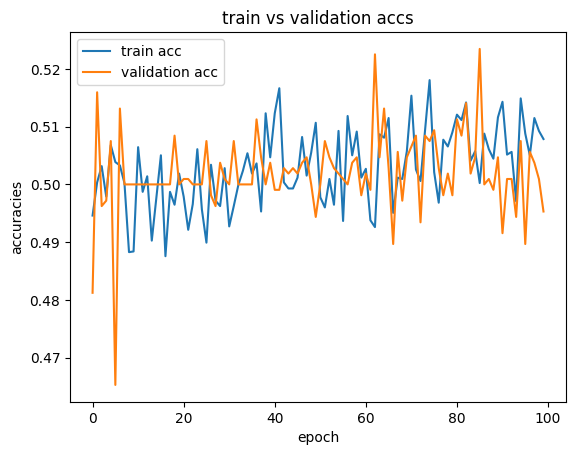

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label="train acc")
plt.plot(validation_acc, label="validation acc")

plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.title("train vs validation accs")
plt.legend()
plt.show()

# Hyperparameter Tuning
We will perform grid search on the no. of training epochs, lr, optimizer and batch sizes

Question 2. RNN
(a) Report the final configuration of your best model, namely the number of training epochs,
learning rate, optimizer, batch size.
(b) Report the accuracy score on the test set, as well as the accuracy score on the validation
set for each epoch during training.
(c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set

In [30]:
test_acc = [] 